In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from typing import Dict, Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from scipy import stats

from procyon.data.data_utils import DATA_DIR
from procyon.data.inference_utils import (
    create_input_retrieval,
    desc_perturbation,
    get_proteins_from_embedding,
)
from procyon.evaluate.framework.utils import move_inputs_to_device
from procyon.model.model_unified import UnifiedProCyon

[2025-02-03 10:24:28,151] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


This notebook contains a minimal example of using a pre-trained ProCyon model to perform a cross-knowledge domain protein retrieval query, as shown in Figure 5F of the main manuscript.

# Load pre-trained model

In [3]:
# Replace with the path where you downloaded a pre-trained ProCyon model (e.g. ProCyon-Full)
checkpoint_path = "~/storage/Lab/PLM/huggingface_repos/ProCyon-Full"
CKPT_NAME = os.path.expanduser(checkpoint_path)

In [4]:
data_args = torch.load(os.path.join(CKPT_NAME, "data_args.pt"))
train_args = torch.load(os.path.join(CKPT_NAME, "training_args.pt"))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, _ = UnifiedProCyon.from_pretrained(checkpoint_dir=CKPT_NAME)
model.bfloat16() # Quantize the model to a smaller precision
model.eval()
model.to(device)

updating model args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct
updating stale DATA_DIR for model arg: go_embeddings_path
updating stale DATA_DIR for model arg: pfam_embeddings_path
updating stale DATA_DIR for model arg: drugbank_embeddings_path
updating stale DATA_DIR for model arg: reactome_embeddings_path
updating stale DATA_DIR for model arg: omim_embeddings_path
updating stale DATA_DIR for model arg: ec_embeddings_path
updating stale DATA_DIR for model arg: protein_seq_embeddings_path
updating stale DATA_DIR for model arg: protein_struct_embeddings_path
updating stale DATA_DIR for model arg: protein_embeddings_idmap_path
updating stale DATA_DIR for model arg: drug_struct_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_idmap_path
updating stale DATA_DIR for model arg: mouse_ortholog_embeddings_path
updating stal

Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.


Processing zero checkpoint '/n/home08/rcalef/storage/Lab/PLM/huggingface_repos/ProCyon-Full/global_step59469'
Detected checkpoint of type zero stage ZeroStageEnum.gradients, world_size: 32
Parsing checkpoint created by deepspeed==0.12.4
Reconstructed fp32 state dict with 322 params 8141117441 elements


UnifiedProCyon(
  (text_encoder): LlamaPostTokenization(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128263, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
              (act_fn): SiLUActivation()
            )
     

In [6]:
# Load saved embeddings for this model
all_protein_embeddings, all_protein_ids = torch.load(os.path.join(CKPT_NAME, "protein_target_embeddings.pkl"))
print(all_protein_embeddings.shape)

torch.Size([18174, 2560])


## Prepare inputs

In [7]:
# Load DrugBank info, namely the mapping from DrugBank IDs to mechanism
# of action descriptions and ProCyon-Instruct numeric IDs.
drugbank_info = pd.read_pickle(os.path.join(
    DATA_DIR,
    "integrated_data",
    "v1",
    "drugbank",
    "drugbank_info_filtered_composed.pkl",
))
db_map = {row["drugbank_id"]: row['moa'] for _, row in drugbank_info.iterrows()}
db_idx_map = {row["drugbank_id"]: row['index'] for _, row in drugbank_info.iterrows()}

In [8]:
# Now provide the high-level task definition, phrased similarly to the ones used in training.
task_desc = """
You will be shown two texts: one describing a disease and one describing a drug.
Your job is to determine the proteins that are a target of the drug described and are indicated for the disease described.
A target of a drug is a protein that the drug binds to, resulting in an alteration of the normal function of the bound molecule and a desirable therapeutic effect. Drug targets are most commonly proteins such as enzymes, ion channels, and receptors.
"""

task_desc = task_desc.replace("\n", " ")

In [9]:
# Next we set up the specific prompt contexts provided for retrieval using
# bupropion and either depression or smoking cessation.

# DrugBank ID for bupropion
db_id = "DB01156"
drug_desc = db_map[db_id]
depression_desc = """The pathophysiology of depression is not completely understood, but current theories center around monoaminergic systems, the circadian rhythm, immunological dysfunction, HPA-axis dysfunction and structural or functional abnormalities of emotional circuits.

Derived from the effectiveness of monoaminergic drugs in treating depression, the monoamine theory posits that insufficient activity of monoamine neurotransmitters is the primary cause of depression. Evidence for the monoamine theory comes from multiple areas. First, acute depletion of tryptophan—a necessary precursor of serotonin and a monoamine—can cause depression in those in remission or relatives of people who are depressed, suggesting that decreased serotonergic neurotransmission is important in depression.[63] Second, the correlation between depression risk and polymorphisms in the 5-HTTLPR gene, which codes for serotonin receptors, suggests a link. Third, decreased size of the locus coeruleus, decreased activity of tyrosine hydroxylase, increased density of alpha-2 adrenergic receptor, and evidence from rat models suggest decreased adrenergic neurotransmission in depression.[64] Furthermore, decreased levels of homovanillic acid, altered response to dextroamphetamine, responses of depressive symptoms to dopamine receptor agonists, decreased dopamine receptor D1 binding in the striatum,[65] and polymorphism of dopamine receptor genes implicate dopamine, another monoamine, in depression.[66][67] Lastly, increased activity of monoamine oxidase, which degrades monoamines, has been associated with depression.[68] However, the monoamine theory is inconsistent with observations that serotonin depletion does not cause depression in healthy persons, that antidepressants instantly increase levels of monoamines but take weeks to work, and the existence of atypical antidepressants which can be effective despite not targeting this pathway.[69]

One proposed explanation for the therapeutic lag, and further support for the deficiency of monoamines, is a desensitization of self-inhibition in raphe nuclei by the increased serotonin mediated by antidepressants.[70] However, disinhibition of the dorsal raphe has been proposed to occur as a result of decreased serotonergic activity in tryptophan depletion, resulting in a depressed state mediated by increased serotonin. Further countering the monoamine hypothesis is the fact that rats with lesions of the dorsal raphe are not more depressive than controls, the finding of increased jugular 5-HIAA in people who are depressed that normalized with selective serotonin reuptake inhibitor (SSRI) treatment, and the preference for carbohydrates in people who are depressed.[71] Already limited, the monoamine hypothesis has been further oversimplified when presented to the general public.[72] A 2022 review found no consistent evidence supporting the serotonin hypothesis, linking serotonin levels and depression.[73]

HPA-axis abnormalities have been suggested in depression given the association of CRHR1 with depression and the increased frequency of dexamethasone test non-suppression in people who are depressed. However, this abnormality is not adequate as a diagnosis tool, because its sensitivity is only 44%.[74] These stress-related abnormalities are thought to be the cause of hippocampal volume reductions seen in people who are depressed.[75] Furthermore, a meta-analysis yielded decreased dexamethasone suppression, and increased response to psychological stressors.[76] Further abnormal results have been obscured with the cortisol awakening response, with increased response being associated with depression.[77]

There is also a connection between the gut microbiome and the central nervous system, otherwise known as the Gut-Brain axis, which is a two-way communication system between the brain and the gut. Experiments have shown that microbiota in the gut can play an important role in depression as people with MDD often have gut-brain dysfunction. One analysis showed that those with MDD have different bacteria living in their guts. Bacteria Bacteroidetes and Firmicutes were most affected in people with MDD, and they are also impacted in people with Irritable Bowel Syndrome.[78] Another study showed that people with IBS have a higher chance of developing depression, which shows the two are connected.[79] There is even evidence suggesting that altering the microbes in the gut can have regulatory effects on developing depression. [78]

Theories unifying neuroimaging findings have been proposed. The first model proposed is the limbic-cortical model, which involves hyperactivity of the ventral paralimbic regions and hypoactivity of frontal regulatory regions in emotional processing.[80] Another model, the cortico-striatal model, suggests that abnormalities of the prefrontal cortex in regulating striatal and subcortical structures result in depression.[81] Another model proposes hyperactivity of salience structures in identifying negative stimuli, and hypoactivity of cortical regulatory structures resulting in a negative emotional bias and depression, consistent with emotional bias studies.[82]

Immune Pathogenesis Theories on Depression
The newer field of psychoneuroimmunology, the study between the immune system and the nervous system and emotional state, suggests that cytokines may impact depression.

Immune system abnormalities have been observed, including increased levels of cytokines -cells produced by immune cells that affect inflammation- involved in generating sickness behavior, creating a pro-inflammatory profile in MDD.[83][84][85] Some people with depression have increased levels of pro-inflammatory cytokines and some have decreased levels of anti-inflammatory cytokines.[86] Research suggests that treatments can reduce pro-inflammatory cell production, like the experimental treatment of ketamine with treatment-resistant depression.[87] With this, in MDD, people will more likely have a Th-1 dominant immune profile, which is a pro-inflammatory profile. This suggests that there are components of the immune system affecting the pathology of MDD. [88]

Another way cytokines can affect depression is in the kynurenine pathway, and when this is overactivated, it can cause depression. This can be due to too much microglial activation and too little astrocytic activity. When microglia get activated, they release pro-inflammatory cytokines that cause an increase in the production of COX2. This, in turn, causes the production of PGE2, which is a prostaglandin, and this catalyzes the production of indolamine, IDO. IDO causes tryptophan to get converted into kynurenine and kynurenine becomes quinolinic acid.[89] Quinolinic acid is an agonist for NMDA receptors, so it activates the pathway. Studies have shown that the post-mortem brains of patients with MDD have higher levels of quinolinic acid than people who did not have MDD. With this, researchers have also seen that the concentration of quinolinic acid correlates to the severity of depressive symptoms."""
depression_prompt = "Disease: {} Drug: {}".format(depression_desc, drug_desc)

smoking_desc = """Smoking cessation: Nicotine is an amine found in tobacco and tobacco products. It is the addictive agent which confers a much lower risk than other elements of tobacco, but it is not completely benign. When tobacco smoke is inhaled, nicotine rapidly enters the bloodstream through the pulmonary circulation. Inhaled nicotine escapes the first pass intestinal and liver metabolism. Nicotine readily crosses the blood-brain barrier which then promptly diffuses into the brain tissue. The process is said to take only 2 to 8 seconds from the time of inhalation. Nicotine is a selective binder to nicotinic cholinergic receptors (nAChRs) in the brain and other tissues. The half-life of nicotine in the human body is estimated to be around 2 hours from the time of consumption.

Brain imaging studies have demonstrated that nicotine acutely increases activity in the prefrontal cortex, thalamus, and visual system consistent with activation of corticobasal ganglia and thalamic brain circuits. Nicotine which stimulates nAChRs produces the release of neurotransmitters, predominantly dopamine but also norepinephrine, acetylcholine, serotonin, GABA, glutamate, and endorphins. These neurotransmitters cause the various responses and behaviors after nicotine intake. When there is repeated exposure to nicotine, tolerance develops to some of the physiological effects of nicotine. Nicotine is a sympathomimetic drug that causes the release of catecholamines and increases heart rate, cardiac contractility, constricts cutaneous and coronary blood vessels and increases blood pressure.

Nicotine undergoes metabolism in the liver, primarily by the liver enzyme CYP2A6, and converts nicotine to cotinine. Cotinine is a metabolite that can be used as a marker for exposure to nicotine. There are broad individual and racial variations in the rate of nicotine metabolism due to genetic polymorphism in CYP2A6. Thus the metabolism of nicotine is faster in Caucasians than Asians and Africans. Sex hormones also significantly affect CYP2A6 activity, and females metabolize nicotine faster than males.[10][11]"""
smoking_prompt = "Disease: {} Drug: {}".format(smoking_desc, drug_desc)

In [10]:
input_simple = create_input_retrieval(
    input_description=depression_prompt,
    data_args=data_args,
    drug_input_idx=db_idx_map[db_id],
    task_definition=task_desc,
    instruction_source_dataset="drugbank",
    instruction_source_relation="drug_target",  # "all" - disgenet, omim, uniprot, reactome
    aaseq_type="protein",
    icl_example_number=1,  # 0, 1, 2
)

input_simple = move_inputs_to_device(input_simple, device=device)
with torch.no_grad():
    model_out = model(
        inputs=input_simple,
        retrieval=True,
        aaseq_type="protein",
    )
df_dep = get_proteins_from_embedding(all_protein_embeddings, model_out, top_k=None)
df_dep

,uniprot_id,name,sim_score
772,P27338,MAOB {ECO:0000312|HGNC:HGNC:6834},0.656250
771,P21397,MAOA {ECO:0000312|HGNC:HGNC:6833},0.644531
13831,P23975,SLC6A2,0.621094
13833,P31645,SLC6A4,0.621094
50,P34969,HTR7,0.613281
...,...,...,...
16906,Q6NVU6,UFSP1,-0.234375
16558,H0UI37,TSTD3,-0.251953
14779,Q537H7,SPATA45,-0.263672
9598,Q9H1M0,NUP62CL,-0.300781


In [11]:
input_simple = create_input_retrieval(
    input_description=smoking_prompt,
    data_args=data_args,
    drug_input_idx=db_idx_map[db_id],
    task_definition=task_desc,
    instruction_source_dataset="drugbank",
    instruction_source_relation="drug_target",  # "all" - disgenet, omim, uniprot, reactome
    aaseq_type="protein",
    icl_example_number=0,  # 0, 1, 2
)

input_simple = move_inputs_to_device(input_simple, device=device)
with torch.no_grad():
    model_out = model(
        inputs=input_simple,
        retrieval=True,
        aaseq_type="protein",
    )

df_smoke = get_proteins_from_embedding(all_protein_embeddings, model_out, top_k=None)
df_smoke

,uniprot_id,name,sim_score
1820,P35219,CA8,0.636719
17107,P54219,SLC18A1,0.636719
17108,Q05940,SLC18A2,0.636719
13831,P23975,SLC6A2,0.632812
1813,P00918,CA2,0.628906
...,...,...,...
16906,Q6NVU6,UFSP1,-0.361328
9598,Q9H1M0,NUP62CL,-0.369141
5024,Q8N5W8,FAM24B,-0.417969
9938,P0CG21,NHLRC4,-0.441406


In [12]:
proteins_of_interest = {
    # Norepinephrine transporter, involved in treating major depressive disorder (MDD)
    "P23975": "NET",
    # Dopamine transporter, contributes to therapeutic mechanism of bupropion for both MDD and smoking cessation
    "Q01959": "DAT",
    # Cholinergic receptor nicotinic alpha 3 subunit, involved in treating smoking cessation
    "P32297": "AChR",
}
for uid, gene_name in proteins_of_interest.items():
    stat = stats.percentileofscore(
        df_dep["sim_score"], df_dep["sim_score"].loc[(df_dep["uniprot_id"] == uid)]
    )[0]
    print("{}: {}".format(gene_name, stat))

NET: 99.98624408495654
DAT: 99.97523935292176
AChR: 99.84318256850446


In [13]:
for uid, gene_name in proteins_of_interest.items():
    stat = stats.percentileofscore(
        df_smoke["sim_score"],
        df_smoke["sim_score"].loc[(df_smoke["uniprot_id"] == uid)],
    )[0]
    print("{}: {}".format(gene_name, stat))

NET: 99.98349290194784
DAT: 99.96423462088698
AChR: 99.16914273137449


## Score resampling via text perturbations

While you've now seen how to get retrieval scores, we'll also show how you can get some error bounds on retrieval scores by slightly perturbing the prompts.

In [14]:
# Convenience function wrapping the whole process we've seen so far.

def ret_crosskd_query(disease_desc: str) -> Dict:
    """Run a single retrieval query."""
    desc = "Disease: {} Drug: {}".format(disease_desc, "Bupropion")
    input_simple = create_input_retrieval(
        input_description=desc,
        data_args=data_args,
        drug_input_idx=db_idx_map[db_id],
        task_definition=task_desc,
        instruction_source_dataset="drugbank",
        instruction_source_relation="drug_target",
        aaseq_type="protein",
        icl_example_number=0,  # 0, 1, 2
    )

    input_simple = move_inputs_to_device(input_simple, device=device)
    with torch.no_grad():
        model_out = model(
            inputs=input_simple,
            retrieval=True,
            aaseq_type="protein",
        )

    df = get_proteins_from_embedding(
        all_protein_embeddings, model_out, top_k=None
    ).reset_index()

    outputs = {}
    for uid in proteins_of_interest.keys():
        stat = df["sim_score"].loc[(df["uniprot_id"] == uid)].index[0]
        outputs[uid] = stat

    return outputs

def calc_stats_from_perturbations(
    perturb_scores: Dict,
) -> Tuple[Dict]:
    """Calculate statistics from perturbed retrieval scores."""
    # Pool together and get error bars:
    pooled = {k: [] for k in perturb_scores["perturb_0"].keys()}
    for _, v in perturb_scores.items():
        for k in v.keys():
            pooled[k].append(v[k])
    # Calc stderr, mean:
    means = {k: np.mean(v) for k, v in pooled.items()}
    stderrs = {k: stats.sem(v) for k, v in pooled.items()}
    return means, stderrs, pooled

In [15]:
# Use descriptions here that emphasize pathophysiology, sourced from NCBI StatPearls
mdd_desc = """The underlying pathophysiology of major depressive disorder has not been clearly defined. Current evidence points to a complex interaction between neurotransmitter availability and receptor regulation and sensitivity underlying the affective symptoms.

Clinical and preclinical trials suggest a disturbance in central nervous system serotonin (5-HT) activity as an important factor. Other neurotransmitters implicated include norepinephrine (NE), dopamine (DA), glutamate, and brain-derived neurotrophic factor (BDNF).

The role of CNS 5-HT activity in the pathophysiology of major depressive disorder is suggested by the therapeutic efficacy of selective serotonin reuptake inhibitors (SSRIs). Research findings imply a role for neuronal receptor regulation, intracellular signaling, and gene expression over time, in addition to enhanced neurotransmitter availability.

Seasonal affective disorder is a form of major depressive disorder that typically arises during the fall and winter and resolves during the spring and summer. Studies suggest that seasonal affective disorder is also mediated by alterations in CNS levels of 5-HT and appears to be triggered by alterations in circadian rhythm and sunlight exposure.

Vascular lesions may contribute to depression by disrupting the neural networks involved in emotion regulation—in particular, frontostriatal pathways that link the dorsolateral prefrontal cortex, orbitofrontal cortex, anterior cingulate, and dorsal cingulate. Other components of limbic circuitry, in particular, the hippocampus and amygdala, have been implicated in depression.."""

smoking_desc = """Nicotine is an amine found in tobacco and tobacco products. It is the addictive agent which confers a much lower risk than other elements of tobacco, but it is not completely benign. When tobacco smoke is inhaled, nicotine rapidly enters the bloodstream through the pulmonary circulation. Inhaled nicotine escapes the first pass intestinal and liver metabolism. Nicotine readily crosses the blood-brain barrier which then promptly diffuses into the brain tissue. The process is said to take only 2 to 8 seconds from the time of inhalation. Nicotine is a selective binder to nicotinic cholinergic receptors (nAChRs) in the brain and other tissues. The half-life of nicotine in the human body is estimated to be around 2 hours from the time of consumption.

Brain imaging studies have demonstrated that nicotine acutely increases activity in the prefrontal cortex, thalamus, and visual system consistent with activation of corticobasal ganglia and thalamic brain circuits. Nicotine which stimulates nAChRs produces the release of neurotransmitters, predominantly dopamine but also norepinephrine, acetylcholine, serotonin, GABA, glutamate, and endorphins. These neurotransmitters cause the various responses and behaviors after nicotine intake. When there is repeated exposure to nicotine, tolerance develops to some of the physiological effects of nicotine. Nicotine is a sympathomimetic drug that causes the release of catecholamines and increases heart rate, cardiac contractility, constricts cutaneous and coronary blood vessels and increases blood pressure.

Nicotine undergoes metabolism in the liver, primarily by the liver enzyme CYP2A6, and converts nicotine to cotinine. Cotinine is a metabolite that can be used as a marker for exposure to nicotine. There are broad individual and racial variations in the rate of nicotine metabolism due to genetic polymorphism in CYP2A6. Thus the metabolism of nicotine is faster in Caucasians than Asians and Africans. Sex hormones also significantly affect CYP2A6 activity, and females metabolize nicotine faster than males."""

In [16]:
mdd_perturbed_scores = desc_perturbation(
    mdd_desc, query_func=ret_crosskd_query, num_perturbations=20, perturbation_pct=0.1, seed=12345
)
smoking_perturbed_scores = desc_perturbation(
    smoking_desc, query_func=ret_crosskd_query, num_perturbations=20, perturbation_pct=0.1, seed=12345
)

100%|███████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


In [17]:
mdd_means, mdd_stderrs, mdd_ranks = calc_stats_from_perturbations(mdd_perturbed_scores)
smoke_means, smoke_stderrs, smoke_ranks = calc_stats_from_perturbations(smoking_perturbed_scores)

In [18]:
results = []
for up_id, name in proteins_of_interest.items():
    results.append(pd.DataFrame({
        "Rank": mdd_ranks[up_id],
        "Protein": name,
        "Disease context": "Major depressive disorder",
    }))
    results.append(pd.DataFrame({
        "Rank": smoke_ranks[up_id],
        "Protein": name,
        "Disease context": "Smoking cessation",
    }))

results = pd.concat(results, ignore_index=True)

In [19]:
results

,Rank,Protein,Disease context
0,5,NET,Major depressive disorder
1,2,NET,Major depressive disorder
2,4,NET,Major depressive disorder
3,2,NET,Major depressive disorder
4,3,NET,Major depressive disorder
...,...,...,...
115,6,AChR,Smoking cessation
116,24,AChR,Smoking cessation
117,6,AChR,Smoking cessation
118,28,AChR,Smoking cessation


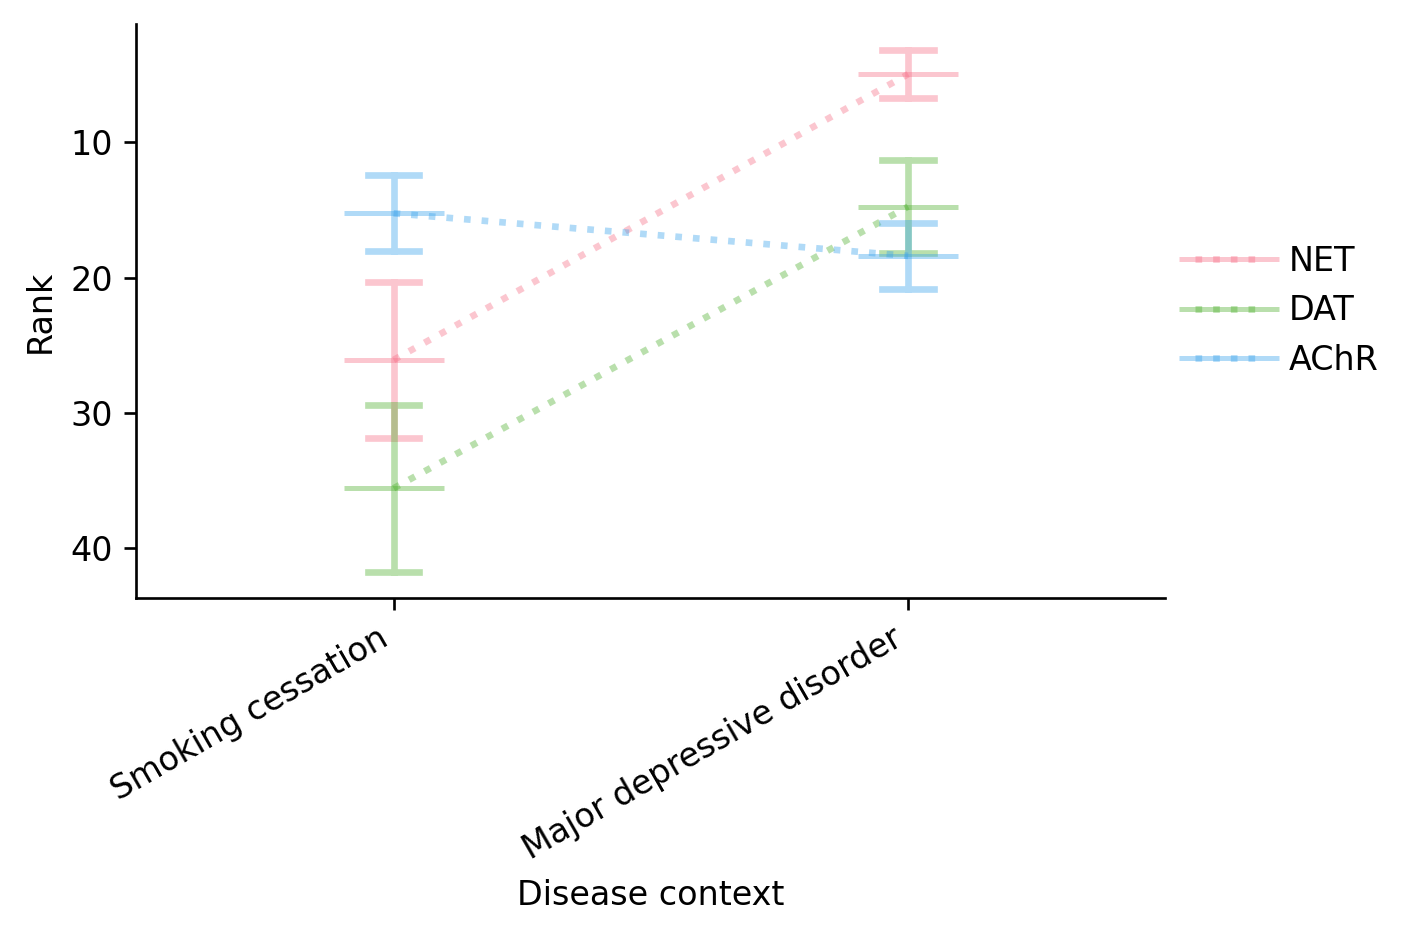

In [20]:
plt.figure(figsize=(6, 4), dpi=240, tight_layout=True)
ax = sns.pointplot(
    data=results,
    x="Disease context",
    hue="Protein",
    y="Rank",
    dodge=False,
    markers="_",
    markersize=30,
    palette="husl",
    linestyles=":",
    linewidth=2,
    errorbar="se",  # ci="se",
    capsize=0.1,
    order=["Smoking cessation", "Major depressive disorder"]
)

for artist in ax.get_lines():
    if isinstance(artist, matplotlib.lines.Line2D):
        artist.set_alpha(0.4)  # Set the alpha value here

plt.xticks(rotation=30, ha="right")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
plt.gca().invert_yaxis()
sns.despine()

plt.show()